<a href="https://colab.research.google.com/github/sadrireza/Neural-Networks/blob/main/SHAP_Inmplemented_to_OCCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
pip install shap

In [7]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Dropout, ReLU
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import accuracy_score
import shap

In [8]:
# Loading Data
training = np.load("FEATURE_TRAINING_COMP.npy")
test = np.load("FEATURE_TEST_COMP.npy")
X_Z = np.load("ANOMALY_Z.npy")

In [9]:
# Label Creation
X = np.append(training, X_Z, axis=0)
L_1 = [1, 0]
L_2 = [0, 1]
Label_1 = [L_1 for i in range(len(training))]
Label_2 = [L_2 for i in range(len(X_Z))]
Label_1 = np.array(Label_1)
Label_2 = np.array(Label_2)
Label = np.append(Label_1, Label_2, axis=0)
hidden_layer = 50

In [10]:
# Create and compile the model
model = Sequential([
    Dense(hidden_layer, input_dim=X.shape[1]),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dense(hidden_layer),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),
    Dense(hidden_layer),
    BatchNormalization(),
    ReLU(),
    Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
# Train the model
X_train, X_test, y_train, y_test = train_test_split(X, Label, test_size=0.3)
kf = KFold(n_splits=5, shuffle=True)
kf.split(X)
accuracy_model = []
z = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Label[train_index], Label[test_index]
    train_report = model.fit(X_train, y_train, epochs=500, validation_data=(X_test, y_test), verbose=0)
    print("******Evaluate on test data with the model:**********", z)
    z += 1
    results = model.evaluate(X_test, y_test)
    print("test loss, test acc:", results)
    print(train_report.history.keys())

model.save('OCC_50_50_2C')

# Load the trained model
model = keras.models.load_model('OCC_50_50_2C')

Exception ignored in: <function _xla_gc_callback at 0x7a84b55e6dd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


******Evaluate on test data with the model:********** 0
53/53 [==============================] - 0s 3ms/step - loss: 0.1411 - accuracy: 0.9435
test loss, test acc: [0.14109566807746887, 0.9434523582458496]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
******Evaluate on test data with the model:********** 1
53/53 [==============================] - 0s 3ms/step - loss: 0.1397 - accuracy: 0.9423
test loss, test acc: [0.13965152204036713, 0.9422619342803955]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
******Evaluate on test data with the model:********** 2
53/53 [==============================] - 0s 3ms/step - loss: 0.1369 - accuracy: 0.9452
test loss, test acc: [0.1369466483592987, 0.9452381134033203]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
******Evaluate on test data with the model:********** 3
53/53 [==============================] - 0s 3ms/step - loss: 0.1326 - accuracy: 0.9476
test loss, test acc: [0.13263100385665894, 0.947619020938873

4/4 [==============================] - 0s 4ms/step


  0%|          | 0/1680 [00:00<?, ?it/s]

19/19 [==============================] - 0s 3ms/step


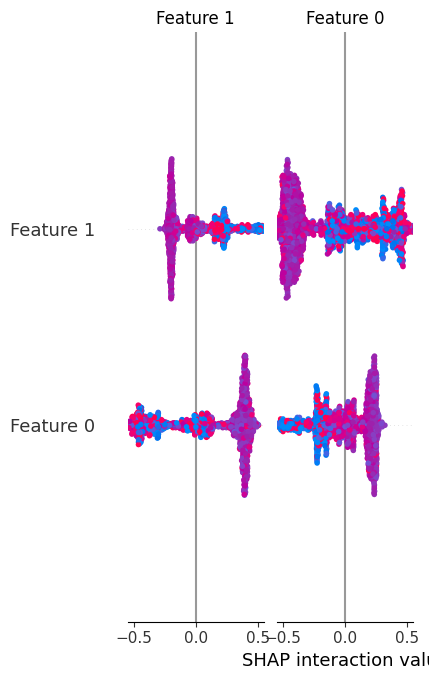

In [16]:
# Create a SHAP explainer using KernelExplainer
# We'll use a small sample from X_train as the background data for KernelExplainer
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
explainer = shap.KernelExplainer(model.predict, background)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test, plot_type="bar")